In [1]:
from __future__ import division, print_function

from collections import defaultdict
import os
import pickle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
f = open('max_chro_pos.pickle')
max_chro_pos = pickle.load(f)
f.close()

window_size = 2000000

def get_blocks():
    for chro, max_pos in max_chro_pos.items():
        num_bin = (max_pos + 1) // window_size
        for my_bin in range(num_bin):
            start_pos = my_bin * window_size + 1
            end_pos = start_pos + window_size
            yield chro, start_pos, end_pos

In [3]:
import multiprocessing
import subprocess
import time

class Local:
    '''Local executor.

    :param limit: CPU load limit

         if limit is an int>0 then it is the expected load average NOT
         to be used, for instance if there are 32 cores and there
         is a limit of 6, the system will try to never ago above 26.
         A float between 0 and 1 will be interpreted as a the
         fraction of CPUs to be used, e.g., with 32 cores, 0.25
         will use at most 8
         A negative value will be interpreted as the maximum number
         of processes that can be executed in parallel.

    This executor will block if there are no more slots available!
    '''

    def __init__(self, limit):
        self.limit = limit
        self.cpus = multiprocessing.cpu_count()
        self.running = []

    def submit(self, command, parameters):
        '''Submits a job
        '''
        self.wait()
        if hasattr(self, 'out'):
            out = self.out
        else:
            out = '/dev/null'
        if hasattr(self, 'err'):
            err = self.err
        else:
            err = '/dev/null'
        if err == 'stderr':
            errSt = ''
        else:
            errSt = '2> ' + err
        p = subprocess.Popen('%s %s > %s %s' %
                             (command, parameters, out, errSt),
                             shell=True)
        self.running.append(p)
        if hasattr(self, 'out'):
            del self.out
        if hasattr(self, 'err'):
            del self.err

    def wait(self, for_all=False):
        '''Blocks if there are no slots available

        :param for_all: Also waits if there is *ANY* job running (i.e.
                    block/barrier)
        '''
        self.clean_done()
        numWaits = 0
        if self.limit > 0 and type(self.limit) == int:
            cond = 'len(self.running) >= self.cpus - self.limit'
        elif self.limit < 0:
            cond = 'len(self.running) >= - self.limit'
        else:
            cond = 'len(self.running) >= self.cpus * self.limit'
        while eval(cond) or (for_all and len(self.running) > 0):
            time.sleep(1)
            self.clean_done()
            numWaits += 1

    def clean_done(self):
        '''Removes dead processes from the running list.
        '''
        dels = []
        for rIdx, p in enumerate(self.running):
            if p.poll() is not None:
                dels.append(rIdx)
        dels.reverse()
        for del_ in dels:
            del self.running[del_]

In [5]:
executor = Local(limit=-4)

In [6]:
for chrom, start_pos, end_pos in get_blocks():
    executor.submit('plink',
                    '--bfile tsi --freq --out tsi-%d-%d --chr %d --from-bp %d --to-bp %d' %
                    (chrom, start_pos, chrom, start_pos, end_pos))
executor.wait(for_all=True)

In [7]:
#SLURM of above on external file
#talk about granularity (computation vs desired)

In [8]:
for chrom, start_pos, end_pos in get_blocks():
    os.remove('tsi-%d-%d.log' % (chrom, start_pos))

In [9]:
for chrom, start_pos, end_pos in get_blocks():
    executor.submit('python', 'get_maf.py %d %d' %
                    (chrom, start_pos))
executor.wait(for_all=True)

In [10]:
#mean and maf
plot_chroms = [1, 13, 22]
chrom_values = defaultdict(list)
for chrom, start_pos, end_pos in get_blocks():
    if chrom not in plot_chroms:
        continue
    block_mafs = pickle.load(open('MAF-%d-%d' % (chrom, start_pos)))
    chrom_values[chrom].append(((start_pos + end_pos) / 2, len(block_mafs)))

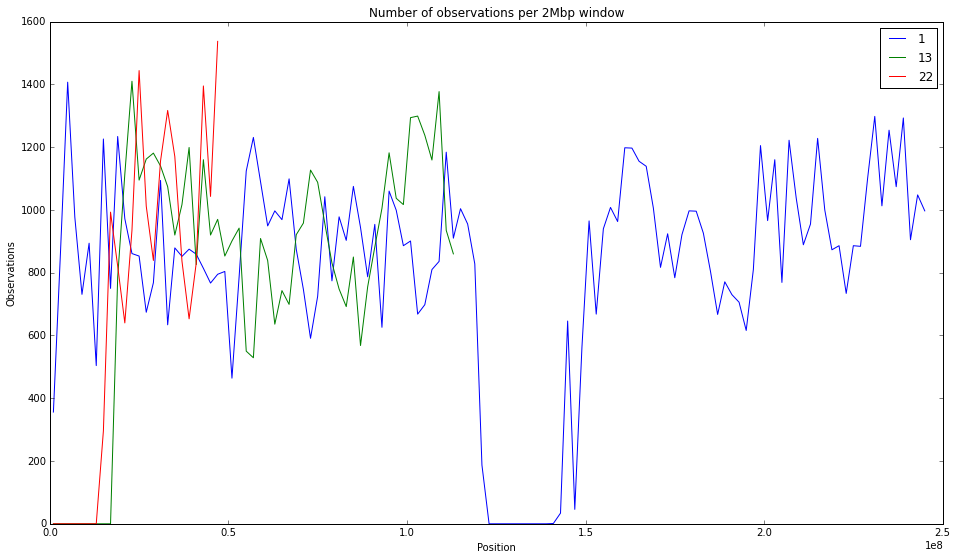

In [11]:
fig = plt.figure(figsize=(16, 9))
ax = fig.add_subplot(111)
ax.set_title('Number of observations per 2Mbp window')
ax.set_xlabel('Position')
ax.set_ylabel('Observations')
for chrom in plot_chroms:
    x, y = zip(*chrom_values[chrom])
    ax.plot(x, y, label=str(chrom))
ax.legend()